In [1]:
# import modules
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [2]:
# This block is for preparing the images for future use. You can load as many as you wish.
# content images
content1_path = keras.utils.get_file("monalisa.jpg", "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1200px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg")
content2_path = keras.utils.get_file("disneycastle.jpg","https://previews.123rf.com/images/holyhikaru/holyhikaru1404/holyhikaru140400019/27731370-orlando-usa-december-20-2013-cinderella-castle-at-walt-disney-world-in-orlando-walt-disney-world-res.jpg")

# style images
style1_path = keras.utils.get_file("great_wave.jpg", "https://img.theculturetrip.com/1440x807/smart/wp-content/uploads/2012/01/hokusai.jpg")
style2_path = keras.utils.get_file("picasso_people.jpg","https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSnPfwSgSwPClgvPLqnRiEVZ8_XWAvyNXEjDg&usqp=CAU")

# other images
other1_path = keras.utils.get_file("white_noise.jpg", "https://images.medicaldaily.com/sites/medicaldaily.com/files/2020/04/23/white-noise.jpg")
other2_path = keras.utils.get_file("pure_white.jpg", "https://wallpaperaccess.com/full/1556608.jpg")
other3_path = keras.utils.get_file("pure_black.jpg", "https://wallpapercave.com/wp/wp3185343.jpg")

16384/15458 [===============================] - 0s 0us/step


In [3]:
# Set your content and style image. Also, specify a base image you want to start from.
content_image_path = content1_path
style_image_path = style2_path
base_image_path = content1_path

result_prefix = "image_generated"

In [4]:
# In this block, you can change the weights, layers and so on.

# Weights of the different loss components
style_weight = 1e-2
content_weight = 1e-3
total_variation_weight = 0

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(content_image_path).size
row_pixel = 512
col_pixel = int(width * row_pixel / height)

# layers to use
# List of layers to use for the style loss.
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layers = "block5_conv2"

# choose your optimizer
optimizer = keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

# iterations
num_iter = 2000

In [5]:
# load pretrained vgg19
vgg = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
vgg.trainable = False

outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])
feature_extractor = keras.Model(inputs=vgg.inputs, outputs=outputs_dict)

80142336/80134624 [==============================] - 1s 0us/step


In [6]:
# image preprocessing/deprocessing
def preprocess_image(image_path):
    image = keras.preprocessing.image.load_img(image_path, target_size=(row_pixel, col_pixel))
    image = keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = keras.applications.vgg19.preprocess_input(image)
    return tf.convert_to_tensor(image)

def deprocess_image(x):
    x = x.reshape((row_pixel, col_pixel, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [7]:
# definition of loss functions
def gram_matrix(tensor):
  channels = int(tensor.shape[-1])
  m = tf.reshape(tensor, [-1, channels])
  n = tf.shape(m)[0]
  gram = tf.matmul(m, m, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def style_loss(style, transfer):
    gram_style = gram_matrix(style)
    gram_transfer = gram_matrix(transfer)
    return tf.reduce_mean(tf.square(gram_style - gram_transfer))

def content_loss(content, transfer):
    return tf.reduce_mean(tf.square(content - transfer))

def total_variation_loss(x):
    a = tf.square(x[:, : row_pixel - 1, : col_pixel - 1, :] - x[:, 1:, : col_pixel - 1, :])
    b = tf.square(x[:, : row_pixel - 1, : col_pixel - 1, :] - x[:, : row_pixel - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [8]:
# compute total loss and gradient
def total_loss(transfer_image, content_image, style_image):
    input_tensor = tf.concat([content_image, style_image, transfer_image], axis=0)
    features = feature_extractor(input_tensor)
    
    loss = tf.zeros(shape=())

    layer_features = features[content_layers]
    content_image_features = layer_features[0, :, :, :]
    transfer_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        content_image_features, transfer_features
    )

    for layer_name in style_layers:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        transfer_features = layer_features[2, :, :, :]
        sl = style_loss(style_features, transfer_features)
        loss += (style_weight / len(style_layers)) * sl

    loss += total_variation_weight * total_variation_loss(transfer_image)
    return loss

@tf.function
def total_loss_and_grads(transfer_image, content_image, style_image):
    with tf.GradientTape() as tape:
        loss = total_loss(transfer_image, content_image, style_image)
    grads = tape.gradient(loss, transfer_image)
    return loss, grads

In [9]:
# initialize and train
content_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)
base_image = tf.Variable(preprocess_image(base_image_path))

# detail the file name
# the name is consist of content image name, style image name, content weight / style rate
# , whether total variation loss is used, and which iteration it reaches.
# E.g. "monalisa+picasso_people+0.1[not used]_at_iteration_100.png"
content_name = content_image_path.split("/")[-1].split(".")[0]
style_name = style_image_path.split("/")[-1].split(".")[0]
alpha_beta_ratio = content_weight/style_weight
total_variatoin_used = "0"
if total_variation_weight == 0:
  total_variatoin_used = "[not used]"
else:
  total_variatoin_used = "[used]"

result_prefix = content_name + "+" + style_name + "+" + str(alpha_beta_ratio) + total_variatoin_used

losses = []
for i in range(1,num_iter+1):
    loss, grads = total_loss_and_grads(
        base_image, content_image, style_image
    )
    optimizer.apply_gradients([(grads, base_image)])
    losses.append(loss)
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(base_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=23633146.00
Iteration 200: loss=8601490.00
Iteration 300: loss=4195050.00
Iteration 400: loss=2547333.00
Iteration 500: loss=1778017.50
Iteration 600: loss=1359089.38
Iteration 700: loss=1111706.00
Iteration 800: loss=950235.69
Iteration 900: loss=835846.56
Iteration 1000: loss=750478.75
Iteration 1100: loss=683613.50
Iteration 1200: loss=629449.88
Iteration 1300: loss=584349.69
Iteration 1400: loss=546348.19
Iteration 1500: loss=513563.22
Iteration 1600: loss=484885.94
Iteration 1700: loss=459529.41
Iteration 1800: loss=436805.28
Iteration 1900: loss=416170.56
Iteration 2000: loss=397480.59


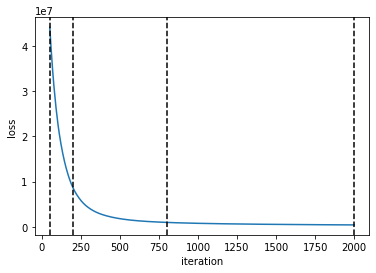

In [10]:
#plot loss
it = range(51,2001)
plt.plot(it, losses[50:])
xposition = [50,200,800,2000]
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [11]:
# display your content and style image
#display(Image(content_image_path))
#display(Image(style_image_path))
#display(Image(base_image_path))

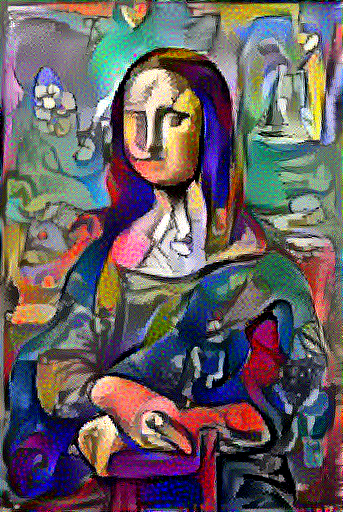

In [12]:
#display(Image(result_prefix + "_at_iteration_4000.png"))
display(Image(result_prefix + "_at_iteration_2000.png"))
#display(Image(result_prefix + "_at_iteration_1000.png"))